# ETRA Challenge Report

In 2019, the [ETRA](https://etra.acm.org/) organization announced a challenge for the analysis of a dataset pertaining to human eye-movement. The objective of the challenge was to utilize various tools to uncover intriguing relationships and information within the data, potentially leading to novel insights. Additional details regarding the challenge can be found in the official  [Challenge Track Call for Papers](https://etra.acm.org/2019/challenge.html) issued by ETRA.

# Setup

For our analysis we will use

- *Jupyter notebooks*,
- ``pandas``, ``numpy``, ``scipy`` for handling data and calculations,
- *PyMC* for bayesian inference,
- ``seaborn``, ``arviz`` for visualization.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import scipy.stats as stats
import pymc as pm

import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az

from etra import read_data

# Apply the default theme
sns.set_theme()

In [2]:
# @formatter:off
%matplotlib inline
# should enable plotting without explicit call .show()

%load_ext pretty_jupyter
#@formatter:on

## Downloading data

Download zip file of the [dataset](http://smc.neuralcorrelate.com/ETRA2019/ETRA2019Challenge.zip). Description of the dataset and how the data was collected can be found on [ETRA dataset description](https://etra.acm.org/2019/challenge.html).

In [3]:
from etra import ETRA

dataset = ETRA(download=False)

The directory ``data`` contains the following directories/files

- ``data/`` : Contains subdirectories containing data of individual participants. Each subdirectory is filled with CSV files, each containing 45 seconds of eye tracker data.
- ``images/`` : Contains the images shown to the participants for each task.
- ``DataSummary.csv`` : Contains mouse clicks of the participants for tasks like Puzzle or Where's Waldo.

# Hypotheses



We will be interested in the following hypotheses:

1. **Is there a point where a participant becomes tired/bored when viewing a scene? (the frequency of saccades decreases) If so, are some scenes less interesting then others?**
    
    There are different types of scenes in the study and some are more visually stimulating then others. For example, it is not unreasonable to expect that a participant will stay much more engaged in a scene with a lot of detail to study then when looking at a blank scene. Another possibility is that during visual searches (picture puzzles, where is Waldo) a participant may become frustrated and just give up on the task. 

    The reasoning behind the way we are going to measure this is as follows. When a participant is engaged in a scene, we assume that their gaze is going to dart across the scene rapidly, as they are studying all the details and the number of saccades during a fixed time frame is going to be very high. On the other hand, when subject becomes bored or frustrated, we might expect that they are going to rest their gaze at some point and not move their eyes very much (maybe just expecting for the experiment to be over) and so the frequency of saccades is going to decrease.

    However, the decrease in frequency of saccades might not be exactly indicative of the subjects boredom or frustration. It is not unlikely that the frequency of saccades is high every time a new scene is introduced and naturally decreases as the subject becomes acquainted with the scene.

    Whatever the reason might be, if there indeed is such a changing point in the frequency of saccades, it might be interesting to study the time for such change and it's relationship to participant, scene and task.


2. **Does the pupil size change depending on scene? What about dependence on task?**

    The motivation behind this hypothesis is that we would like to study the excitement of a subject viewing some scene or performing some task. One of the indicators of excitement might be the change in pupil size (i.e. we expect pupil to dilate during excitement and contract otherwise).

    There are various tasks and scenes and the level of excitement (pupil dilation) might differ in each:
    - in **picture puzzles** we might expect that the level of excitement is kept high during the whole duration, peaking when subject finds a difference
    - in _**Where is Waldo?**_ puzzle we might expect the level of excitement being low as the subject is having difficulties finding Waldo and peaking when (if) Waldo is found
    - viewing a **blank scene** might not excite much

    Therefore, it is interesting to ask which tasks and scenes are the most stimulating and whether any significant distinction can be made.

In [4]:
subject_no = 22

# Hypothesis 1: Saccade Frequency

We will restrict ourselves only to the following hypothesis:
 - $H_0$ (null hypothesis) : The frequency of saccades does not decrease when viewing a scene.
 - $H_1$ (alternative hypothesis) : The frequency of saccades decreases at some point in the trial.

## Load Data

We will restrict ourselves only to one subject. We have arbitrarily chosen the participant with ID ``022``. We select and load all _Free Viewing_ data with ``Natural`` and ``Blank`` scenes. We will be interested in columns
- ``time`` : Indicating the time in milliseconds from the beggining of the trail.
- ``x``, ``y`` : The position on the screen where the participant was looking at the given time.

In [5]:
df_hyp1 = (dataset.data_dir / "data" / "{0:0>3}".format(subject_no)).glob("*FreeViewing_*.csv")
df_hyp1 = pd.concat((read_data(f) for f in df_hyp1)).sort_values(by="Time")

df_hyp1 = df_hyp1.rename({"Time": "time", "trial_id": "trial", "LXpix": "x", "LYpix": "y", "RP": 'rp'}, axis=1)
df_hyp1["time"] = df_hyp1.groupby(["participant_id", "trial"])["time"].transform(lambda x: x - x.min())
df_hyp1 = df_hyp1[['participant_id', 'trial', 'fv_fixation', 'task_type', 'stimulus_id',
       'time', 'x', 'y', 'rp']]

In [6]:
df_hyp1.head()

,participant_id,trial,fv_fixation,task_type,stimulus_id,time,x,y,rp
0,022,001,FreeViewing,Puzzle,puz008,0,454.42,317.175,585
1,022,001,FreeViewing,Puzzle,puz008,2,454.66,312.000,585
2,022,001,FreeViewing,Puzzle,puz008,4,453.30,312.375,585
3,022,001,FreeViewing,Puzzle,puz008,6,454.10,309.450,587
4,022,001,FreeViewing,Puzzle,puz008,8,454.82,310.725,585


## Data manipulation

First step of the pre-processing will be to remove the blinks. We look at the pupil size and consider every value smaller than some threshold to be an indication of a blink. The The Database of Useful Biological Numbers lists the [average pupil size](https://bionumbers.hms.harvard.edu/bionumber.aspx?id=105349&ver=4&trm=pupil+size&org=) to be between 1 and 8 mm. We set 1 mm as our threshold. We will then discard a portion of our data around such points. The [average blink duration](https://bionumbers.hms.harvard.edu/bionumber.aspx?id=100706&ver=4&trm=blink+&org=) ranges between 100 and 400 ms. We delete another 200 ms before and after each blink/semi-blink to eliminate the initial and final parts in which the pupil was still partially occluded.

In [7]:
def remove_blinks(data : pd.DataFrame, column='rp'):
    ans = data.copy()
    n_rows = ans.shape[0]
    
    lows = np.where(ans['rp'].lt(100))[0]
    for low in lows:
        ans.loc[max(0, low-40):min(low+40, n_rows), column] = pd.NA
        
    return ans.dropna()

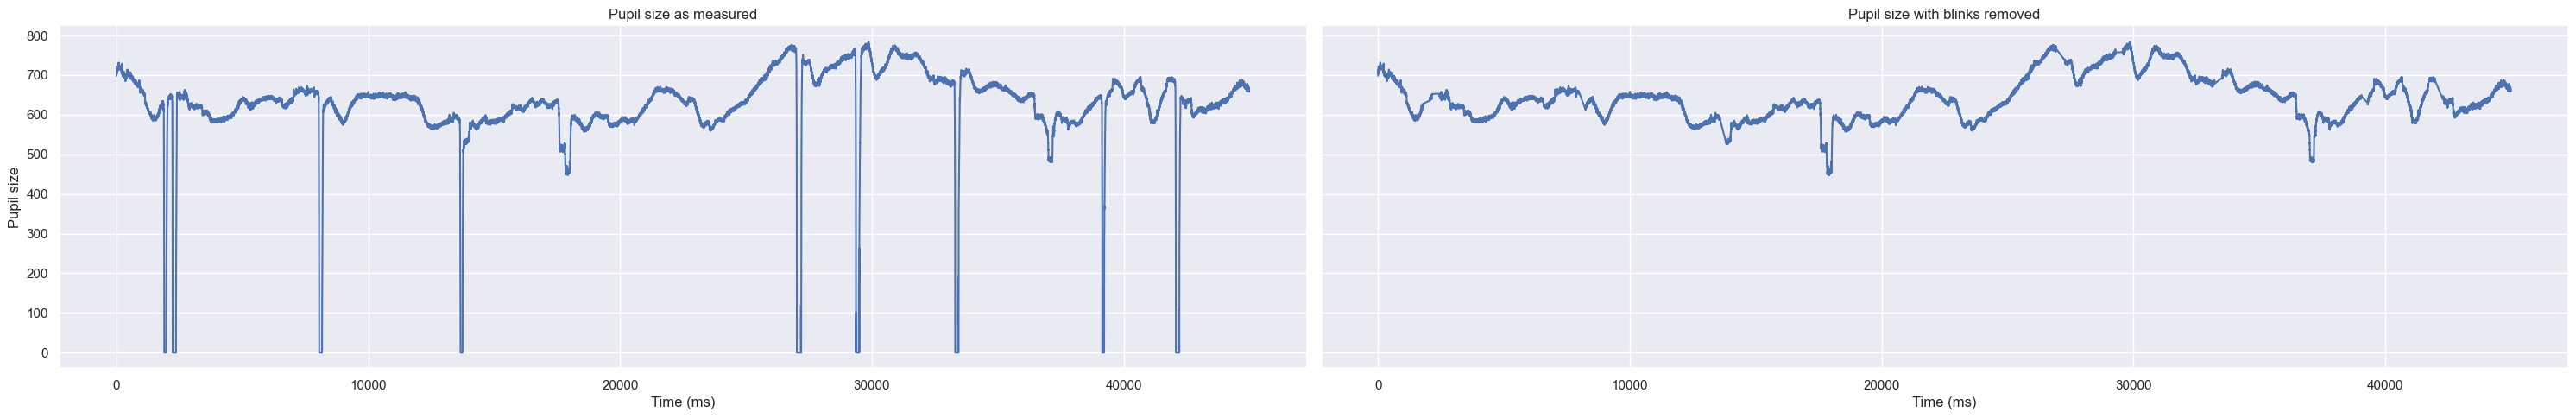

In [8]:
before = df_hyp1[df_hyp1.trial == '106'].assign(blinks_removed='No')
after = remove_blinks(before).assign(blinks_removed='Yes')
hlp = pd.concat([before, after])

g = sns.relplot(data=hlp, x='time', y='rp', kind='line', col='blinks_removed', aspect=3)
g.set_xlabels("Time (ms)")
g.set_ylabels("Pupil size")
g.axes[0, 0].set_title("Pupil size as measured")
g.axes[0, 1].set_title("Pupil size with blinks removed");

For each trial, we will detect saccades using the [REMoDNaV](https://github.com/psychoinformatics-de/remodnav) python library. This gives us the start and end times of saccades (and other events) as well as additional information such as start and end position of the gaze or peak velocity. We will consider only the start times of the saccades and disregard all other data.

In [9]:
# -.-|m { input: true, output: false, output_error: false, input_fold: show }
from etra import detect
import logging

# Disable warnings from the remodnav library
logging.getLogger('remodnav.clf').setLevel(logging.ERROR)

def detect_saccades_by_groups(data, groupby=["participant_id", "trial"]):
    ans = []
    groups = data.groupby(groupby)
    for (pid, trial), group in groups:
        tmp = remove_blinks(group)
        tmp = detect(group)
        tmp = tmp[tmp["label"] == "SACC"]
        tmp["participant_id"] = pid
        tmp["trial"] = trial
        ans.append(tmp)
    
    return pd.concat(ans)

In [10]:
df_hyp1_natural = df_hyp1[df_hyp1.task_type == "Natural"]
df_hyp1_natural_sacc = detect_saccades_by_groups(
    df_hyp1_natural
)

df_hyp1_blank = df_hyp1[df_hyp1.task_type == "Blank"]
df_hyp1_blank_sacc = detect_saccades_by_groups(
    df_hyp1_blank
)

trial_info_natural = df_hyp1_natural[['participant_id', 'trial', 'fv_fixation', 'task_type', 'stimulus_id']].drop_duplicates()
df_hyp1_natural_sacc = trial_info_natural.merge(df_hyp1_natural_sacc, on=[
    "participant_id", "trial"], how="left")
df_hyp1_natural_sacc = df_hyp1_natural_sacc[['participant_id', 'trial', 'fv_fixation', 'task_type', 'stimulus_id', 'start_time']]

trial_info_blank = df_hyp1_blank[['participant_id', 'trial', 'fv_fixation', 'task_type', 'stimulus_id']].drop_duplicates()
df_hyp1_blank_sacc = trial_info_blank.merge(df_hyp1_blank_sacc, on=[
    "participant_id", "trial"], how="left")
df_hyp1_blank_sacc = df_hyp1_blank_sacc[['participant_id', 'trial', 'fv_fixation', 'task_type', 'stimulus_id', 'start_time']]

In [11]:
df_hyp1_natural_sacc.head()

,participant_id,trial,fv_fixation,task_type,stimulus_id,start_time
0,022,003,FreeViewing,Natural,nat010,258
1,022,003,FreeViewing,Natural,nat010,480
2,022,003,FreeViewing,Natural,nat010,670
3,022,003,FreeViewing,Natural,nat010,1166
4,022,003,FreeViewing,Natural,nat010,1266


## Methodology and Exploration

To help us understand how we should model the observations, we first look at the distribution of saccades in time. The x axis represents the time from the start of a trial and each row is a sequence of dots representing the start time of a saccade.

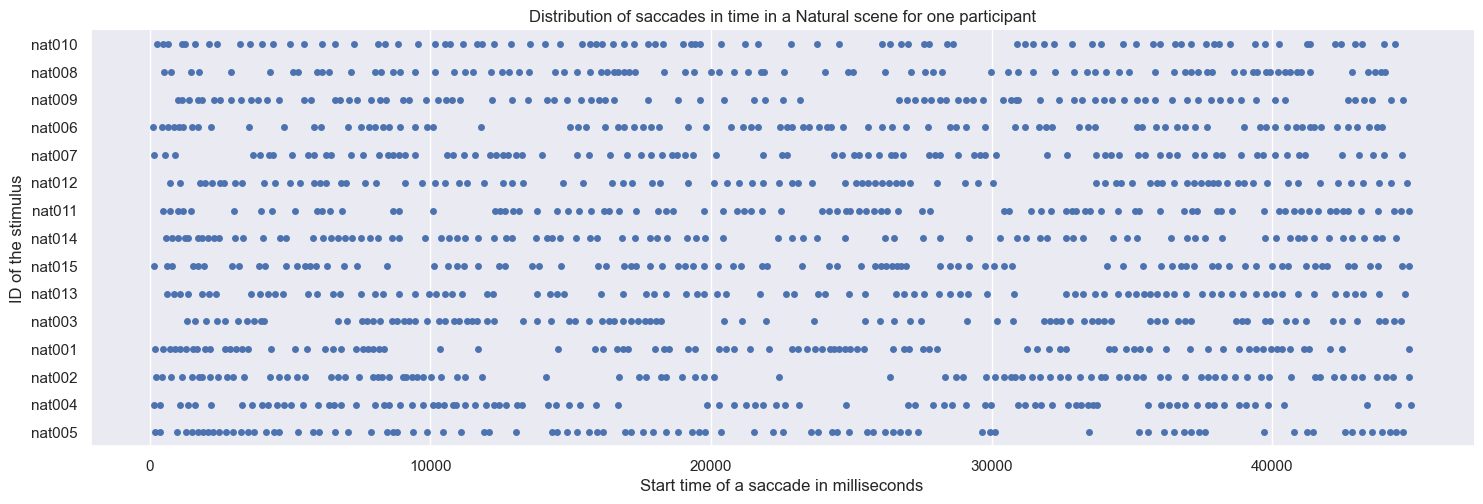

In [12]:
# Plot the distriution of saccades in time
g = sns.catplot(
    data=df_hyp1_natural_sacc,
    x='start_time',
    y='stimulus_id',
    jitter=False,
    aspect=3,
)
g.set_xlabels("Start time of a saccade in milliseconds")
g.set_ylabels("ID of the stimulus")
g.set(title="Distribution of saccades in time in a Natural scene for one participant");

As the occurance of a saccade is a complex process that depends on the scene viewed, mental state of the participant, tiredness or maybe even things like personal history, eyesight, mood and many other factors, it is impossible for us to accurately predict the occurance of the next saccade. To simplify the situation, we might look at it as on a stochastic process, where for some small enough time interval, we have a fixed probability for an occurance of a saccade.

Let $N_t$ be a variable counting the number of saccades in a time interval $[0,t]$.
Our assumption can be formulated as
$$
\lim_{t \to 0} \Pr[N_t \ge 1]/t = \lambda
$$
for some $\lambda \in \mathbb{R}^+$. That is, the probability of an saccade in a small time interval $[0, t]$ tends to $\lambda t$.

Due to physical human limitations, we also have
$$
\lim_{t \to 0} \Pr[N_t \ge 2]/t = 0
$$
or said differently, for a small enough time interval, it is impossible to have two or more successive saccades.

The number of saccades in some interval $[t, s]$ can be expressed then as $N(t) - N(s)$. Additionally, we will assume that for any two disjoint time intervals $[t_1, t_2]$ and $[t_3, t_4]$, the distribution of $N(t_2) - N(t_1)$ is independent of the distribution of $N(t_4) - N(t_3)$.
 
With these assumtions in place, we are justified to model the occurances of saccades as a _Poisson process_ with rate $\lambda$.

In [13]:
def saccade_frequency_count_by_second(data):
    """ Count the number of saccades in each second of the trial """
    
    bins = (data.start_time // 1000).value_counts().sort_index()
    data = pd.DataFrame({"time": range(45)})
    data["sacc_count"] = bins
    data.fillna(0, inplace=True)
    data.sacc_count = data.sacc_count.astype(int)
    
    return data

The theory of Poisson processes then tells us that the number of saccades in some time period of length $t$ is a Poisson random variable with expectation $\lambda t$. We will divide the time of the experiment to seconds (so $t = 1$)  and count the number of saccades in each second. Below is a graph of such counts for one chosen trial.

In [14]:
# Chose one scene as an example
#stimulus = df_hyp1_natural_sacc.stimulus_id.sort_values().unique()[0]
stimulus = "nat013"
scene = df_hyp1_natural_sacc[df_hyp1_natural_sacc.stimulus_id == stimulus]

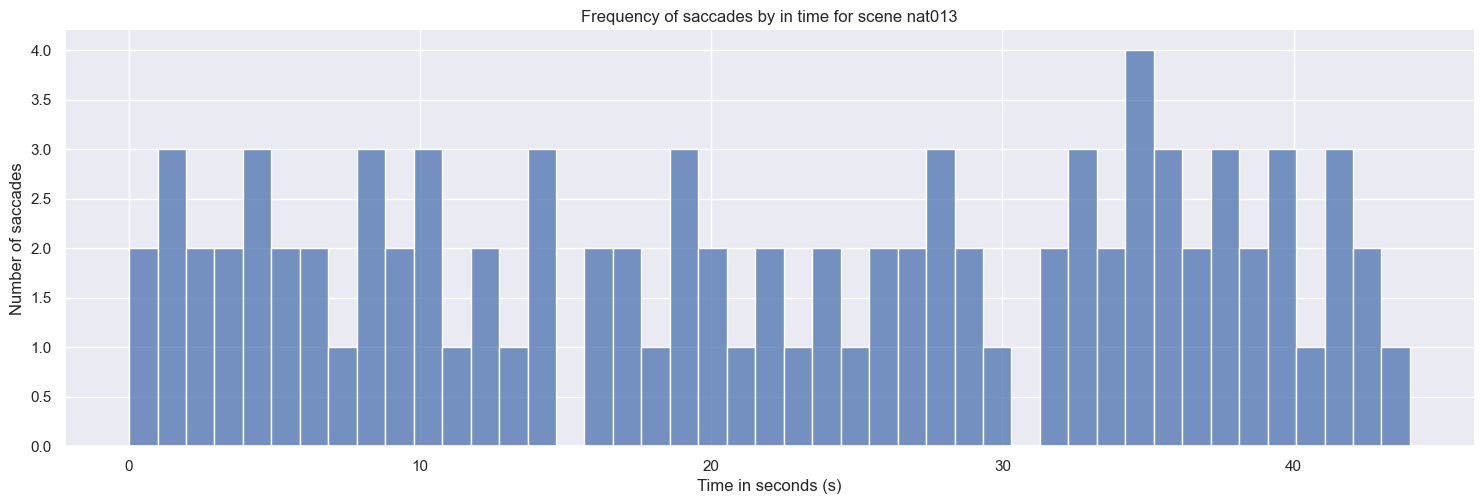

In [15]:
hlp = scene.copy()
hlp.start_time = hlp.start_time.apply(lambda ms: ms // 1000)

g = sns.displot(data=hlp, x='start_time', bins=45, stat="count", aspect=3)
g.set_xlabels("Time in seconds (s)")
g.set_ylabels("Number of saccades")
g.set(title=f"Frequency of saccades by in time for scene {stimulus}");

We are looking for a change in behaviour in behaviour in our participants. To model it we will assume that in some initial time interval the number of saccades will follow some Poisson process with rate $\lambda_1$ up until some time $\tau$ after which _something_ changes and the saccades will follow a different process with rate $\lambda_2$.

Let $S_t$ denote the count of saccades at time $t$. We have
$$
    S_t \sim \mathrm{Poisson}(\lambda^{(t)})
$$
However, we don't know what the parameter $\lambda^{(t)}$ is. It might be either $\lambda_1$ or $\lambda_2$
depending on where we put the changing point $\tau$, so
$$
    \lambda^{(t)} = \begin{cases}
        \lambda_1 && t < \tau \\
        \lambda_2 && t \ge \tau
    \end{cases}
$$

We will try to infer these variables from our data using Bayesian statistics. We will need to choose prior distributions to do that. For $\lambda_1$ and $\lambda_2$ we need to choose from continouous distribution that is able to obtain (potentionally) all positive values. Exponential distribution is that satisfies this requirement, so we set
$$
\begin{align*}
    \lambda_1 \sim \mathrm{Exp}(\alpha)\\
    \lambda_2 \sim \mathrm{Exp}(\alpha)
\end{align*}
$$
where $\alpha$ is some hyper-parameter. As we have no prior knowledge about $\tau$, we simply choose
$$
    \tau \sim \mathrm{Unif}(0, 44)
$$

To help with the inference, we set the hyperparameter $\alpha$ such that
$$
    \frac{1}{\alpha} = \mathbb{E}[\lambda \mid \alpha] \approx \frac{1}{45} \sum_{t = 0}^{44} S_t
$$
which is _about_ the value we would expect the $\lambda$s to be distributed around.

For our modelling we will use the [PyMC](https://www.pymc.io/welcome.html) implementation of Monte Carlo Markov Chains, using the NUTS sampler with default parameters to generate $5000$ samples from the posterior distribution.

In [16]:
def model_saccades(data):
    # Get the count data for one chosen trial
    count_data = saccade_frequency_count_by_second(data)
    count_data = count_data.sacc_count
    n_count_data = count_data.shape[0]
    
    with pm.Model() as model:
        alpha = 1.0/count_data.mean()

        lambda_1 = pm.Exponential("lambda_1", alpha)
        lambda_2 = pm.Exponential("lambda_2", alpha)

        tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data - 1)

        index = np.arange(n_count_data)
        lambda_ = pm.math.switch( tau >= index, lambda_1, lambda_2 )
        
        delta = pm.Deterministic("delta", lambda_2 - lambda_1)

        observation = pm.Poisson("obs", lambda_, observed=count_data)
        
    return model

In [17]:
# -.-|m { input: true, output: false, output_error: false, input_fold: show }

model = model_saccades(scene)
with model:
    trace = pm.sample(5_000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_1, lambda_2]
>Metropolis: [tau]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 10 seconds.


Below, we plot the posterior distributions of the parameters $\tau$, $\lambda_1$, $\lambda_2$ and $\Delta = \lambda_2 - \lambda_1$.

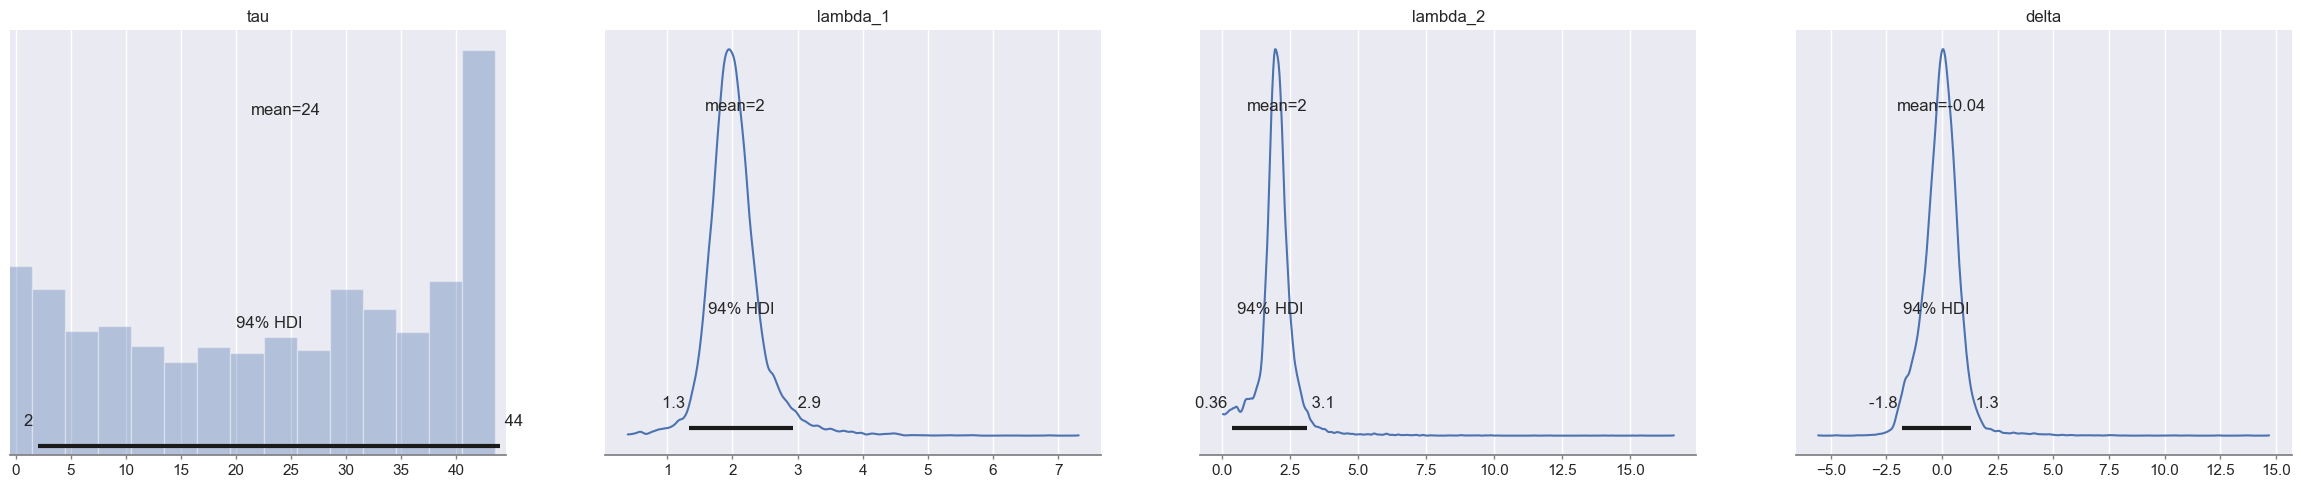

In [18]:
g = az.plot_posterior(trace);

We also list the summarry statistics from the trace of the chain.

In [19]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
tau,24.494,14.778,2.000,44.000,0.460,0.333,943.0,2031.0,1.01
lambda_1,2.041,0.446,1.341,2.934,0.009,0.007,3004.0,2349.0,1.00
lambda_2,2.001,0.796,0.362,3.122,0.013,0.009,3766.0,1904.0,1.00
delta,-0.040,0.924,-1.787,1.296,0.016,0.012,2982.0,2429.0,1.00


Notice that the posterior distribution of $\Delta$ is centered around 0, leading us to believe there is no change in the the rate of saccades. In case there was a change, we would expect a shift either to the positive or negative side. This notion is further reinforced by looking at the Highest Density Interval (HDI) of the posterior distribution of $\tau$ which basically spans the entire duration of the trial.

In [20]:
p_l2_gt_l1 = np.mean(trace.posterior["delta"].values >= 0)

In [21]:
%%jinja markdown

We are also able to calculate 
$$
\Pr[H_0] = \Pr[\lambda_2 \ge \lambda_1] = {{ "{:0.3}".format(p_l2_gt_l1)}}
$$

As the probability is quite high, we do not reject the null hypothesis in this example.


We are also able to calculate 
$$
\Pr[H_0] = \Pr[\lambda_2 \ge \lambda_1] = 0.485
$$

As the probability is quite high, we do not reject the null hypothesis in this example.

### Natural scenes

We do the same analysis as above for all trials using _Natural_ scenes for subject ``022``.

In [22]:
# -.-|m { input: true, output: false, output_error: false, input_fold: show }

stimuli_natural = df_hyp1_natural_sacc.stimulus_id.unique()
stimuli_natural.sort()
#stimuli_natural = stimuli_natural[:3]
chains_natural = []
for stimulus in stimuli_natural:
    trial = df_hyp1_natural_sacc[df_hyp1_natural_sacc.stimulus_id == stimulus]
    model = model_saccades(trial)
    with model:
        chain = pm.sample(5_000)
        chains_natural.append(chain)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_1, lambda_2]
>Metropolis: [tau]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 8 seconds.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_1, lambda_2]
>Metropolis: [tau]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 8 seconds.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_1, lambda_2]
>Metropolis: [tau]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 10 seconds.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_1, lambda_2]
>Metropolis: [tau]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 10 seconds.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_1, lambda_2]
>Metropolis: [tau]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 9 seconds.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_1, lambda_2]
>Metropolis: [tau]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 12 seconds.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_1, lambda_2]
>Metropolis: [tau]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 10 seconds.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_1, lambda_2]
>Metropolis: [tau]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 10 seconds.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_1, lambda_2]
>Metropolis: [tau]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 11 seconds.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_1, lambda_2]
>Metropolis: [tau]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 11 seconds.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_1, lambda_2]
>Metropolis: [tau]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 9 seconds.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_1, lambda_2]
>Metropolis: [tau]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 10 seconds.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_1, lambda_2]
>Metropolis: [tau]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 11 seconds.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_1, lambda_2]
>Metropolis: [tau]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 8 seconds.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_1, lambda_2]
>Metropolis: [tau]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 9 seconds.


In [23]:
combined_natural = []
for stimulus, chain in zip(stimuli_natural, chains_natural):
    df = chain.posterior.to_dataframe()
    df["stimulus"] = stimulus
    combined_natural.append(df)
    
combined_natural = pd.concat(combined_natural)
combined_natural = combined_natural.assign(abs_delta=lambda _: np.abs(_['delta']))

We plot the density estimate for $\Delta$ for all trials.

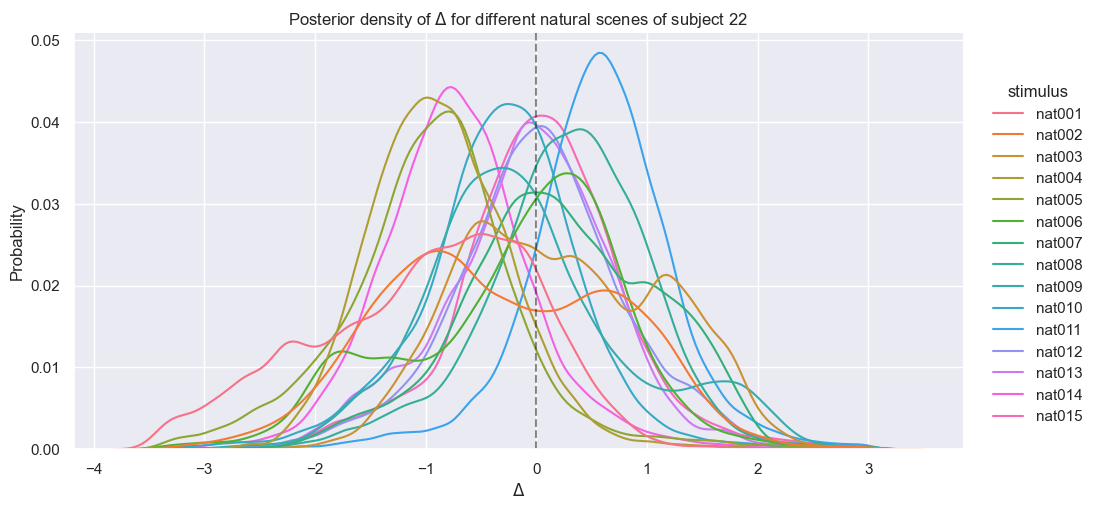

In [24]:
statistic = "delta"
# Truncate values to 99% most plausible
low, up = combined_natural.delta.quantile([0.005, 0.995])
hlp = pd.DataFrame()
hlp[statistic] = combined_natural[statistic].where(combined_natural[statistic].between(low, up))
hlp["stimulus"] = combined_natural["stimulus"]
hlp.reset_index(inplace=True)

g = sns.displot(data=hlp, x=statistic, hue="stimulus", kind="kde", aspect=2)
g.ax.axvline(0, color='k', ls='dashed', alpha=0.5)
g.set_xlabels("$\Delta$")
g.set_ylabels("Probability")
g.set(title=f"Posterior density of $\Delta$ for different natural scenes of subject {subject_no}");

In [25]:
p_l1_gt_l2_natural_combined = (combined_natural.delta >= 0).mean()

There does seem to be some variability from scene to scene, however, from the graph we can still see that _on average_ the change of the frequencies seems to be centered around zero, even shifted sligtly toward the negative side meaning that the frequency of saccades seems to _decrease_ slightly as time progresses.

### Blank scenes

We now repeat the exact same procedure, but for trials with blank scene.

In [26]:
# -.-|m { input: true, output: false, output_error: false, input_fold: show }

trials_blank = df_hyp1_blank_sacc.trial.unique()
trials_blank.sort()
#trials_blank = trials_blank[:3]
chains_blank = []
for trial in trials_blank:
    trial_data = df_hyp1_blank_sacc[df_hyp1_blank_sacc.trial == trial]
    model = model_saccades(trial_data)
    with model:
        chain = pm.sample(5_000)
        chains_blank.append(chain)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_1, lambda_2]
>Metropolis: [tau]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 10 seconds.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_1, lambda_2]
>Metropolis: [tau]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 9 seconds.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_1, lambda_2]
>Metropolis: [tau]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 8 seconds.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_1, lambda_2]
>Metropolis: [tau]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 8 seconds.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_1, lambda_2]
>Metropolis: [tau]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 9 seconds.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_1, lambda_2]
>Metropolis: [tau]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 10 seconds.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_1, lambda_2]
>Metropolis: [tau]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 9 seconds.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_1, lambda_2]
>Metropolis: [tau]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 9 seconds.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_1, lambda_2]
>Metropolis: [tau]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 8 seconds.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_1, lambda_2]
>Metropolis: [tau]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 8 seconds.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_1, lambda_2]
>Metropolis: [tau]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 7 seconds.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_1, lambda_2]
>Metropolis: [tau]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 9 seconds.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_1, lambda_2]
>Metropolis: [tau]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 8 seconds.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_1, lambda_2]
>Metropolis: [tau]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 13 seconds.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_1, lambda_2]
>Metropolis: [tau]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 13 seconds.


In [27]:
combined_blank = []
for trial, chain in zip(trials_blank, chains_blank):
    df = chain.posterior.to_dataframe()
    df["trial"] = trial
    combined_blank.append(df)
    
combined_blank = pd.concat(combined_blank)
combined_blank = combined_blank.assign(abs_delta=lambda _: np.abs(_['delta']))

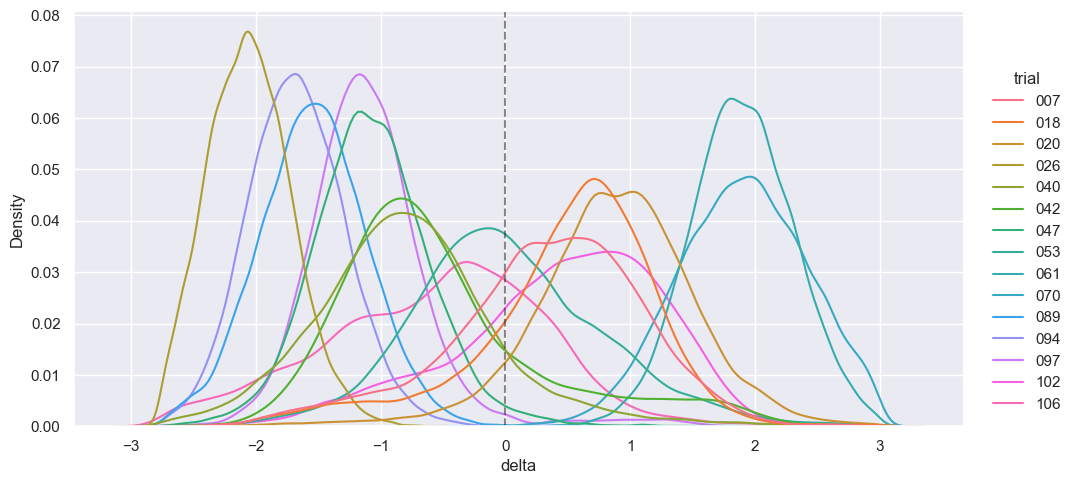

In [28]:
statistic = "delta"
# Truncate values to 99% most plausible
low, up = combined_blank.delta.quantile([0.005, 0.995])
hlp = pd.DataFrame()
hlp[statistic] = combined_blank[statistic].where(combined_blank[statistic].between(low, up))
hlp["trial"] = combined_blank["trial"]
hlp.reset_index(inplace=True)

g = sns.displot(data=hlp, x="delta", hue="trial", kind="kde", aspect=2)
g.ax.axvline(0, color='k', ls='dashed', alpha=0.5);

In [29]:
p_l2_gt_l1_094 = (combined_blank[combined_blank.trial == "094"].delta < 0).mean()
p_l2_gt_l1_070 = (combined_blank[combined_blank.trial == "070"].delta > 0).mean()
p_l1_gt_l2_blank_combined = (combined_blank.delta < 0).mean()

In [30]:
%%jinja markdown

The situation here is much more diverse in this case. We can see that we can find trials on both ends of the spectrum when considering the change in frequency of saccades. For example, for the trial ``094`` we have $\Pr[ \lambda_2 < \lambda_1] = {{p_l2_gt_l1_094}}$, so there is a very high probability of a _decrease_ in the frequency of saccades at some point in the trial.
On the other hand, for trial ``061`` we have $\Pr[ \lambda_2 > \lambda_1] = {{p_l2_gt_l1_070}}$, meaning a high ptobability of _increase_ in frequency.

This seems quite surprising as one might expect consistent behaviour when viewing the same blank scene multiple times.


The situation here is much more diverse in this case. We can see that we can find trials on both ends of the spectrum when considering the change in frequency of saccades. For example, for the trial ``094`` we have $\Pr[ \lambda_2 < \lambda_1] = 0.9995$, so there is a very high probability of a _decrease_ in the frequency of saccades at some point in the trial.
On the other hand, for trial ``061`` we have $\Pr[ \lambda_2 > \lambda_1] = 0.99945$, meaning a high ptobability of _increase_ in frequency.

This seems quite surprising as one might expect consistent behaviour when viewing the same blank scene multiple times.

In [31]:
%%jinja markdown

## Results

Considering all natural scenes as a whole, the probability that the frequency of saccades does not decrease is
$$
\Pr[H_0] = \Pr[ \lambda_2 \ge \lambda_1] \approx {{ "{:0.3}".format(p_l1_gt_l2_natural_combined)}}
$$
which is not low enough to reject the null hypothesis

Considering all the blank trials as a whole, the probability of increase in saccades is
$$
\Pr[H_0] = \Pr[ \lambda_2 \ge \lambda_1] \approx {{ "{:0.3}".format(p_l1_gt_l2_blank_combined)}}
$$
which is not low enough to reject the null hypothesis


## Results

Considering all natural scenes as a whole, the probability that the frequency of saccades does not decrease is
$$
\Pr[H_0] = \Pr[ \lambda_2 \ge \lambda_1] \approx 0.418
$$
which is not low enough to reject the null hypothesis

Considering all the blank trials as a whole, the probability of increase in saccades is
$$
\Pr[H_0] = \Pr[ \lambda_2 \ge \lambda_1] \approx 0.581
$$
which is not low enough to reject the null hypothesis

## Discussion

In this section, we will examine certain assumptions that may have influenced the outcome of our model. One assumption made is that the distribution of saccades is independent of the selected time interval for examination. However, it is possible that the number of saccades may vary over time due to factors such as participant fatigue.

Additionally, we have assumed that there is a single point of change within the data. However, it is feasible that there may be multiple points of change or that the change may occur gradually. Further exploration of these possibilities may serve as a means for model improvement.

Furthermore, our model utilizes specific priors for the parameters. While we have chosen what we believe to be conservative priors, alternative options such as Half-Cauchy or Truncated Normal distributions for the $\lambda$s should also be considered. Additionally, the selection of hyperparameters should be evaluated. We claim that the choice of hyperparameters did not have a significant impact on the model's results and served primarily to improve the speed of convergence of the chain.

Lastly, we did not take into account the examination of trials as a cohesive unit. Each trial was analyzed individually, but it is possible that the order, type and difficulty of prior trials may have affected performance on subsequent trials.

# Hypothesis 2: Pupil dilation

We will study the following hypotheses:
 - $H_0^{(T)}$ (null hypothesis) : The mean pupil size is equal when comparing Blank scene and a type T scene
 - $H_1^{(T)}$ (alternative hypothesis) : The mean pupil size is _not_ equal when comparing Blank scene and a type T scene

## Load Data

Again, we will limit our analysis to data collected from a single participant, specifically participant ID ``022``. The participant was selected arbitrarily. We have selected and loaded all data collected during the "Free Viewing" task. Our focus will be on the following columns of the dataset:

- ``time``: representing the time in milliseconds elapsed from the beginning of the trial.
- ``rp``: indicating the size of the right pupil.

In [32]:
df_hyp2 = (dataset.data_dir / "data" / "{0:0>3}".format(subject_no)).glob("*FreeViewing_*.csv")
df_hyp2 = pd.concat((read_data(f) for f in df_hyp2)).sort_values(by="Time")

df_hyp2 = df_hyp2.rename({"Time": "time", "trial_id": "trial", "RP": "rp"}, axis=1)
df_hyp2["time"] = df_hyp2.groupby(["participant_id", "trial"])["time"].transform(lambda x: x - x.min())

df_hyp2 = df_hyp2[['participant_id', 'trial', 'fv_fixation', 'task_type', 'stimulus_id',
       'time','rp']]

In [33]:
df_hyp2.head()

,participant_id,trial,fv_fixation,task_type,stimulus_id,time,rp
0,022,001,FreeViewing,Puzzle,puz008,0,585
1,022,001,FreeViewing,Puzzle,puz008,2,585
2,022,001,FreeViewing,Puzzle,puz008,4,585
3,022,001,FreeViewing,Puzzle,puz008,6,587
4,022,001,FreeViewing,Puzzle,puz008,8,585


## Data Manipulation

Again, we remove the blinks and then calculate the mean pupil size for each trial.

In [34]:
df_hyp2_avg_rp = df_hyp2.groupby("trial")\
    .apply(remove_blinks)\
    .reset_index(drop=True)\
    .groupby(["trial", "task_type"])\
    .agg(avg_rp=('rp', 'mean'))\
    .reset_index()\
    .drop("trial", axis=1)

In [35]:
df_hyp2_avg_rp.head().round(decimals=2)

,task_type,avg_rp
0,Puzzle,734.91
1,Waldo,664.90
2,Natural,596.14
3,Blank,554.77
4,Waldo,657.94


## Exploration

Looking at the box plot, we can see that there except for the "Natural" scenes there are no significant outliers in any other categories.

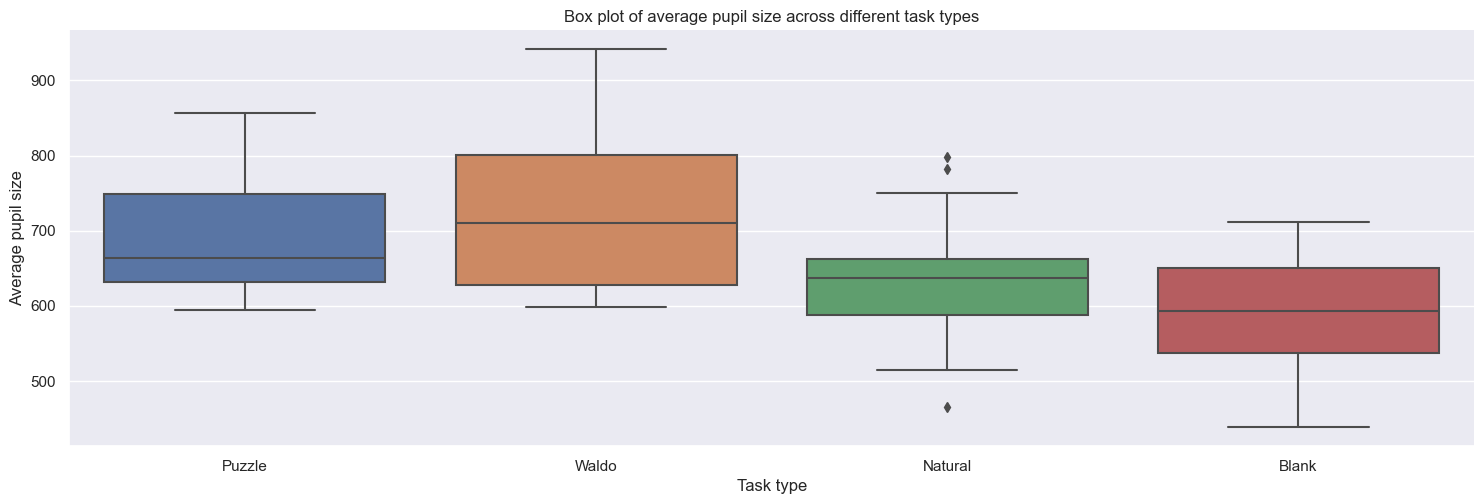

In [36]:
g = sns.catplot(data=df_hyp2_avg_rp, x='task_type', y='avg_rp', kind='box', aspect=3);
g.set_xlabels("Task type")
g.set_ylabels("Average pupil size")
g.set(title="Box plot of average pupil size across different task types");

In [37]:
df_hyp2_avg_rp.groupby("task_type").describe().round(decimals=2)

avg_rp                                                        
           count    mean     std     min     25%     50%     75%     max
task_type                                                               
Blank       15.0  589.78   89.22  438.20  537.63  592.73  650.43  711.32
Natural     15.0  635.84   91.14  464.97  587.33  636.75  662.73  797.62
Puzzle      15.0  699.44   89.15  594.43  631.53  664.14  748.29  856.61
Waldo       15.0  724.14  112.28  598.10  627.82  709.60  801.23  941.75

Let us look at the distribution of the means. If we want to use t-test, we want our data to be roughly normally distributed.

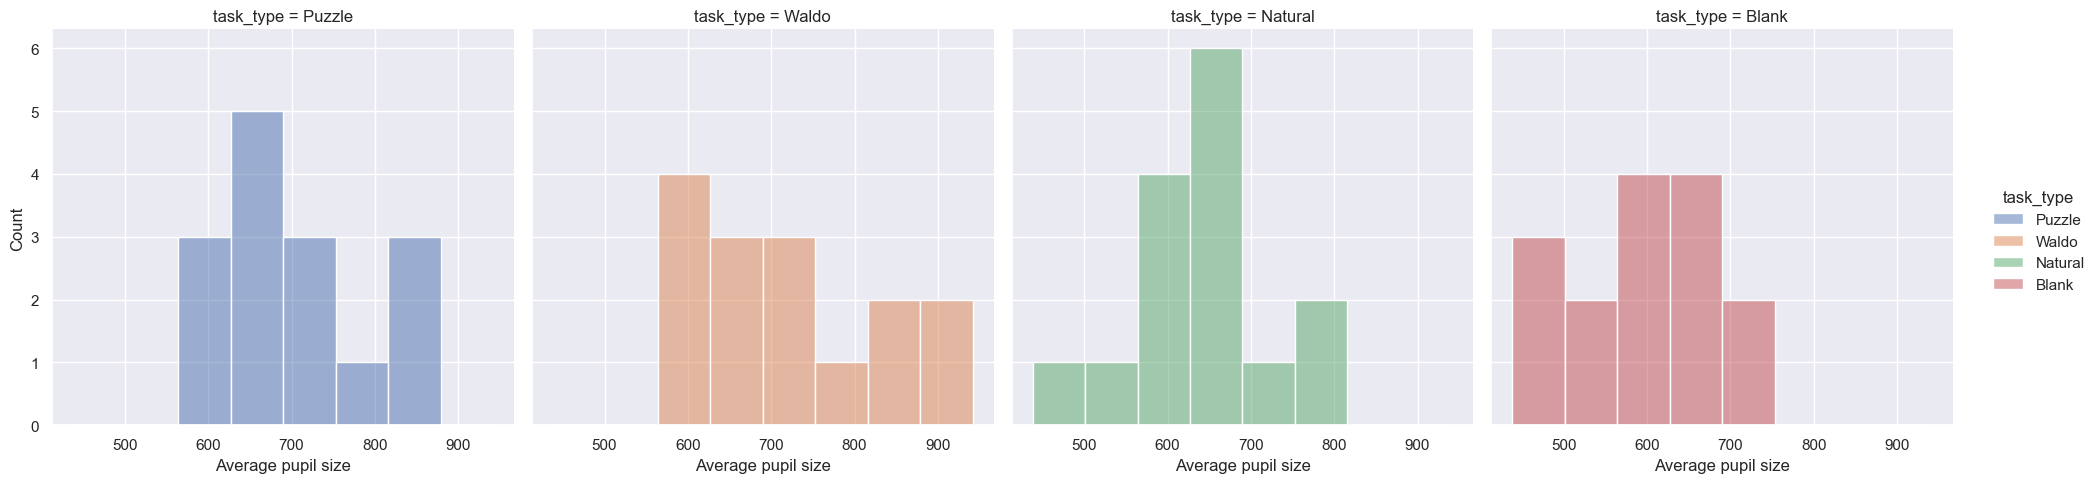

In [38]:
g = sns.displot(data=df_hyp2_avg_rp, x='avg_rp', hue='task_type', col="task_type")
g.set_xlabels("Average pupil size")
g.set_ylabels("Count");

Looking at the graphs, the distribution of the data seems to be roughly normal, however it is hard to gauge this from such a small sample size. We use the Shapiro-Wilk test, which tests the null hypothesis that the data was drawn from a normal distribution.

In [39]:
print("Resulting p-values from the Shapiro-Wilk test:\n")
for task_type in ["Blank", "Puzzle", "Waldo", "Natural"]:
    shapiro_result = stats.shapiro(df_hyp2_avg_rp[df_hyp2_avg_rp.task_type == task_type].avg_rp)
    print("\t{}\t: {:0.3}".format(task_type, shapiro_result.pvalue))

Resulting p-values from the Shapiro-Wilk test:

	Blank	: 0.374
	Puzzle	: 0.0556
	Waldo	: 0.142
	Natural	: 0.592


Using signifance level of 5%, we conclude that the data is distributed normally (although this is a bit debatable in the case of "Waldo" task).

## Results

Given that we are evaluating the same participant across different tasks, it is appropriate to use the paired t-test as the data points are linked to one another. This statistical test allows for the comparison of each task with our chosen baseline, which is the blank scene.

In [40]:
baseline = "Blank"

print("Resulting p-values from the paired t-test:\n")
for task_type in ["Puzzle", "Waldo", "Natural"]:
    ttest_result = stats.ttest_ind(
        df_hyp2_avg_rp[df_hyp2_avg_rp.task_type == baseline].avg_rp,
        df_hyp2_avg_rp[df_hyp2_avg_rp.task_type == task_type].avg_rp,
    )
    print("\t{}\t: {:0.3}".format(task_type, ttest_result.pvalue))

Resulting p-values from the paired t-test:

	Puzzle	: 0.00222
	Waldo	: 0.00113
	Natural	: 0.173


Thus we reject the null hypothesis for the _Puzzle_ and _Waldo_ tasks, meaning the mean pupil size is different (greater as can be seen from the box plots). We were not able to reject the null hypothesis in case of the _Natural_ task. 

## Discussion

Another interesting metric to consider might be the number of times the pupil size peaks and the count of such peaks.

# References
- [ETRA 2019 Challenge Track Call for Papers](https://etra.acm.org/2019/challenge.html)
- M. Mitzenmacher, E. Upfal: Probability and Computing: Randomized Algorithms and Probabilistic Analysis, Cambridge University Press, 2005
- [Probabilistic Programming & Bayesian Methods for Hackers](https://dataorigami.net/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/)
- Dar, A. H., Wagner, A. S. & Hanke, M. (2019). [REMoDNaV: Robust Eye Movement Detection for Natural Viewing](https://doi.org/10.1101/619254). *bioRxiv*. DOI: ``10.1101/619254``